# Graphs for paper for combinations

In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True


In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"


In [4]:
import sys
sys.path.append('../')


In [5]:
import neptune


In [534]:
## download from neptune
LOC_START_ID, LOC_END_ID = 1799, 1963
LOC_RUN_IDS = [f"TSDRLOC-{i}" for i in range(LOC_START_ID, LOC_END_ID + 1) if i not in LOC_SKIP_IDS]


In [428]:
def convert_to_dataset_name(target_app: str, middleware: bool, manually_selected: bool) -> str:
    match target_app, middleware, manually_selected:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination: {target_app}, {middleware}, {manually_selected}")


In [433]:
def fetch_metadata(run_id: str, granularity: str = "cg") -> dict[str, str]:
    with neptune.init_run(
        project="yuuk1/tsdr-localization",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"].fetch() == True:
            return {}

        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"]["tsdr"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        multi_dist_type = tsdr_params.get("step2_dbscan_dist_type", "")

        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "MetricSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBS-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBS-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        # 1. e-Diagnosis
        # 2. RCD
        # 3. CausalRCA+PageRank
        # 4. PC+RW-2
        # 5. GES+RW-2
        # 6. LiNGAM+RW-2
        # 7. PC+PageRank
        # 8. GES+PageRank
        # 9. LiNGAM+PageRank
        # 10. PC+HT
        # 11. GES+HT
        # 12. LiNGAM+HT
        localization: str
        loc_params = run["parameters"].fetch()
        pyrca_method = loc_params.get("method", "")
        walk_method = loc_params.get("walk_method", "")

        if pyrca_method == "epsilon_diagnosis":
            localization = "e-Diagnosis"
        elif loc_params.get("use_rcd", False):
            localization = "RCD"
        elif loc_params.get("use_causalrca", False):
            localization = "CausalRCA"
        elif pyrca_method == "pc" and walk_method == "rw-2":
            localization = "PC+RW-2"
        elif pyrca_method in ["ges", "fges"] and walk_method == "rw-2":
            localization = "GES+RW-2"
        elif pyrca_method == "lingam" and walk_method == "rw-2":
            localization = "LiNGAM+RW-2"
        elif pyrca_method == "call_graph" and walk_method == "rw-2":
            localization = "CG+RW-2"
        elif pyrca_method == "pc" and walk_method == "pagerank":
            localization = "PC+PageRank"
        elif pyrca_method in ["ges", "fges"] and walk_method == "pagerank":
            localization = "GES+PageRank"
        elif pyrca_method == "lingam" and walk_method == "pagerank":
            localization = "LiNGAM+PageRank"
        elif pyrca_method == "call_graph" and walk_method == "pagerank":
            localization = "CG+PageRank"
        elif pyrca_method == "pc" and walk_method == "ht":
            localization = "PC+HT"
        elif pyrca_method in ["ges", "fges"] and walk_method == "ht":
            localization = "GES+HT"
        elif pyrca_method == "lingam" and walk_method == "ht":
            localization = "LiNGAM+HT"
        elif pyrca_method == "call_graph" and walk_method == "ht":
            localization = "CG+HT"
        else:
            assert False, f"Unknown localization method: {loc_params}, RUN_ID: {run_id}"

        match granularity:
            case "cg":
                metric = run["scores"]["metric"].fetch()
                ac2 = metric["AC_2_mand"]
                ac5 = metric["AC_5_mand"]
                avg5 = metric["AVG_5_mand"]
                elapsed_time = run["elapsed_time"]["mean"]["elapsed_time"].fetch()
                return {"dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                            "reduction_method": reduction, "localization_method": localization,
                            "ac@2": ac2, "ac@5": ac5, "avg@5": avg5, "elapsed_time": elapsed_time}
            case "fg":
                path = f"/tmp/score-df-by-cause-comp-and-type-{run_id}.html"
                run["eval/score-df-by-cause-comp-and-type"].download(path)
                df = pd.concat(pd.read_html(path), axis=1)
                df.rename(
                    columns={
                        "Unnamed: 0": "dataset_id", "Unnamed: 1": "target_app", "Unnamed: 2": "chaos_comp", "Unnamed: 3": "chaos_type", "Unnamed: 4": "top_k"},
                    inplace=True,
                )

                path2 = f"/tmp/elapsed-time-df-by-cause-comp-and-type-{run_id}.html"
                run["elapsed_time/mean_by_chaos_type_and_chaos_comp"].download(path2)
                df2 = pd.concat(pd.read_html(path2), axis=1)
                df2.columns = df2.columns.set_levels(["chaos_type", "chaos_comp", "elapsed_time"], level=0)
                df2.columns = df2.columns.droplevel(1)
                elapsed_times = df2.set_index(["chaos_type", "chaos_comp"]).to_dict()["elapsed_time"]

                items = []
                for name, group in df.groupby(
                    ["dataset_id", "target_app", "chaos_comp", "chaos_type"], as_index=False,
                ):
                    ac_2 = group.loc[group["top_k"] == 2, "AC@K (metric) (mandatory)"].values[0]
                    ac_5 = group.loc[group["top_k"] == 5, "AC@K (metric) (mandatory)"].values[0]
                    avg_5 = group.loc[group["top_k"] == 5, "AVG@K (metric) (mandatory)"].values[0]
                    chaos_type = group["chaos_type"].iat[0]
                    chaos_comp = group["chaos_comp"].iat[0]
                    elapsed_time = elapsed_times[(chaos_type, chaos_comp)]
                    items.append({
                        "run_id": run_id,
                        "dataset": convert_to_dataset_name(group["target_app"].iat[0], middleware, manually_selected),
                        "reduction_method": reduction, "localization_method": localization,
                        "chaos_comp": chaos_comp, "chaos_type": chaos_type,
                        "ac@2": ac_2, "ac@5": ac_5, "avg@5": avg_5, "elapsed_time": elapsed_time,
                    })
                return items
            case _:
                assert False, f"Unknown granularity: {granularity}"


In [535]:
import joblib

items = joblib.Parallel(n_jobs=64)(joblib.delayed(fetch_metadata)(run, granularity="fg") for run in LOC_RUN_IDS)
assert items is not None
items = [item for item in items if item]
items = sum(items, [])
# assert len(items) <= len(LOC_RUN_IDS), f"{len(items)} > {len(LOC_RUN_IDS)}"


https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1814
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1817
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1810
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1820
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1811
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1821
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1808
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1807
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1818
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1825
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1830
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1812
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1803
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1805
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1819
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1824
https://

In [536]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    loc_tsdr_df = pd.DataFrame(items)
    _loc_df = loc_tsdr_df.sort_values(["run_id", "dataset", "reduction_method", "localization_method", "chaos_comp", "chaos_type"], ascending=False).drop_duplicates(subset=["dataset", "reduction_method", "localization_method", "chaos_comp", "chaos_type"], keep="first")
    display(
        _loc_df.groupby(["dataset", "reduction_method", "localization_method"])[["ac@2", "ac@5", "avg@5", "elapsed_time"]].agg("mean")
    )


ac@2      ac@5     avg@5  \
dataset   reduction_method localization_method                                 
SS-large  BIRCH            RCD                  0.106250  0.130000  0.122875   
          FluxInfer-AD     RCD                  0.125000  0.130000  0.126833   
          HDBS-R           RCD                  0.118750  0.070833  0.093333   
          HDBS-SBD         RCD                  0.100000  0.075833  0.083500   
          K-S test         RCD                  0.131250  0.130833  0.126792   
          MetricSifter     RCD                  0.112500  0.153333  0.128375   
          NSigma           RCD                  0.106250  0.141667  0.119583   
          None             RCD                  0.087500  0.137500  0.113125   
SS-medium BIRCH            CG+PageRank          0.006250  0.012500  0.010417   
                           RCD                  0.331250  0.392500  0.343708   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          FluxInfer-AD     CG+PageRank          0.018750  0.016667  0.015417   
                           RCD                  0.312500  0.362500  0.328333   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          HDBS-R           CG+PageRank          0.012500  0.024167  0.012958   
                           RCD                  0.212500  0.198333  0.220917   
                           e-Diagnosis          0.006250  0.022500  0.012625   
          HDBS-SBD         CG+PageRank          0.025000  0.037500  0.029375   
                           RCD                  0.312500  0.222500  0.258458   
                           e-Diagnosis          0.000000  0.022500  0.012208   
          K-S test         CG+PageRank          0.012500  0.012500  0.011042   
                           RCD                  0.331250  0.360000  0.338458   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          MetricSifter     CG+PageRank          0.021875  0.038125  0.031948   
                           RCD                  0.368750  0.461667  0.393583   
                           e-Diagnosis          0.018750  0.040625  0.028542   
          NSigma           CG+PageRank          0.025000  0.024167  0.021708   
                           RCD                  0.300000  0.396667  0.339958   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          None             CG+PageRank          0.018750  0.029167  0.025208   
                           RCD                  0.300000  0.368333  0.325125   
                           e-Diagnosis          0.000000  0.000000  0.000000   
SS-small  BIRCH            CG+PageRank          0.050000  0.039167  0.040750   
                           LiNGAM+HT            0.162500  0.152500  0.163000   
                           LiNGAM+PageRank      0.137500  0.108333  0.131667   
                           PC+HT                0.231250  0.172500  0.204917   
                           PC+PageRank          0.081250  0.081667  0.086958   
                           RCD                  0.306250  0.226667  0.263250   
                           e-Diagnosis          0.031250  0.025000  0.030208   
          FluxInfer-AD     CG+PageRank          0.025000  0.028333  0.028375   
                           LiNGAM+HT            0.193750  0.169167  0.186333   
                           LiNGAM+PageRank      0.131250  0.112500  0.126250   
                           PC+HT                0.212500  0.174167  0.203375   
                           PC+PageRank          0.068750  0.070833  0.074375   
                           RCD                  0.300000  0.236667  0.279625   
                           e-Diagnosis          0.037500  0.031667  0.032792   
          HDBS-R           CG+PageRank          0.025000  0.033333  0.021667   
                           LiNGAM+HT            0.150000  0.101667  0.137000   
                           LiNGAM+PageRank      0.10

## Load tsdr

In [455]:
TSDR_START_ID, TSDR_END_ID = 1765, 1835
TSDR_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_START_ID, TSDR_END_ID + 1)]


In [482]:
def fetch_metadata_of_tsdr(run_id: str, granurality: str = "cg") -> dict[str, str|float]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return {}
        try:
            dataset = run["dataset"].fetch()
            target_app = dataset["target_app"]
            middleware = dataset["metric_types"]["middlewares"]
            manually_selected = dataset["use_manually_selected_metrics"]
        except neptune.exceptions.MissingFieldException:
            return {}

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type

        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "MetricSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBS-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBS-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        try:
            scores = run["scores"].fetch()
        except neptune.exceptions.MissingFieldException as e:
            print(f"Missing scores: RUN_ID {run_id}")
            return {}
        try:
            _ = run["scores/cause_metrics"].fetch()
        except neptune.exceptions.MissingFieldException as e:
            print(f"Missing scores: RUN_ID {run_id}")
            return {}

        match granurality:
            case "cg":
                tp = scores["cause_metrics"]["tp_mean"]
                tn = scores["cause_metrics"]["tn_mean"]
                fn = scores["cause_metrics"]["fn_mean"]
                fp = scores["cause_metrics"]["fp_mean"]
                recall = scores["cause_metrics"]["recall_mandatory_mean"]
                specificity = scores["cause_metrics"]["specificity_mean"]
                frr = scores["reduction_rate_mean"]
                proportion = scores["cause_metrics"]["proportion_mandatory_mean"]
                f1_score = scores["cause_metrics"]["f1_score_mean"]
                mcc = scores["cause_metrics"]["mcc_mean"]
                bacc = scores["cause_metrics"]["bacc_mean"]

                num_series = tuple([int (s) for s in scores["num_series"]["total"].split("/")])
                num_found_cause_metrics = scores["cause_metrics"]["num_mandatory_found_mean"]
                elapsed_time = scores["elapsed_time"]
                return {
                    "run_id": run_id,
                    "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                    "reduction_method": reduction,
                    "tp": tp, "tn": tn, "fn": fn, "fp": fp,
                    "specificity": specificity, "recall": recall, "proportion": proportion,
                    "f1_score": f1_score, "mcc": mcc, "bacc": bacc,
                    "reduction_rate": frr,
                    "elapsed_time": elapsed_time,
                    "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                    "rs_ac@2": scores["RS_AC_2"], "rs_ac@5": scores["RS_AC_5"], "rs_avg@5": scores["RS_AVG_5"],
                }
            case "fg":
                csv_path = f"/tmp/summary_by_chaos_type_and_chaos_comp-{run_id}.csv"
                run["scores/summary_by_chaos_type_and_chaos_comp-csv"].download(csv_path)
                df = pd.read_csv(csv_path)
                last_phase = df["phase"].drop_duplicates().sort_values().iat[-1]
                df = df[df["phase"] == last_phase].set_index(["chaos_type", "chaos_comp", "phase"]).sort_index()
                items = []
                for index, row in df.iterrows():
                    tp = row["cause_metrics/tp_mean"]
                    tn = row["cause_metrics/tn_mean"]
                    fn = row["cause_metrics/fn_mean"]
                    fp = row["cause_metrics/fp_mean"]
                    recall = row["cause_metrics/recall_mandatory_mean"]
                    specificity = row["cause_metrics/specificity_mean"]
                    frr = row["reduction_rate_mean"]
                    proportion = row["cause_metrics/proportion_mandatory_mean"]
                    f1_score = row["cause_metrics/f1_score_mean"]
                    mcc = row["cause_metrics/mcc_mean"]
                    bacc = row["cause_metrics/bacc_mean"]

                    num_series = tuple([int (s) for s in row["num_series/total"].split("/")])
                    num_found_cause_metrics = row["cause_metrics/num_mandatory_found_mean"]
                    elapsed_time = row["elapsed_time"]
                    items.append({
                        "run_id": run_id,
                        "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                        "reduction_method": reduction,
                        "tp": tp, "tn": tn, "fn": fn, "fp": fp,
                        "specificity": specificity, "recall": recall, "proportion": proportion,
                        "f1_score": f1_score, "mcc": mcc, "bacc": bacc,
                        "reduction_rate": frr,
                        "elapsed_time": elapsed_time,
                        "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                        "rs_ac@2": row["RS_AC_2"], "rs_ac@5": row["RS_AC_5"], "rs_avg@5": row["RS_AVG_5"],
                        "chaos_type": index[0], "chaos_comp": index[1],
                    })
                return items
            case _:
                assert False, f"Unknown granularity: {granurality}"


In [469]:
tsdr_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run, granurality="cg") for run in TSDR_RUN_IDS)
assert tsdr_items is not None
tsdr_items = [item for item in tsdr_items if item]
assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"


https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1779
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1783
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1774
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1791
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1778
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1781
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1785
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1766
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1773
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1775
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1789
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1776
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1792
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1769
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1768
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1772
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1782
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1771
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1788
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1786
https://app.neptune.ai/yuuk1/tsdr/

In [476]:
tsdr_fg_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run, granurality="fg") for run in TSDR_RUN_IDS)
assert tsdr_fg_items is not None
tsdr_fg_items = [item for item in tsdr_fg_items if item]
tsdr_fg_items = sum(tsdr_fg_items, [])
# assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"


https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1786
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1790
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1771
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1765
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1768
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1778
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1784
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1770
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1785
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1766
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1775
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1774
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1769
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1781
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1783
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1787
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1788
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1776
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1782
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1773
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1777
https://app.neptune.ai/yuuk1/tsdr/

In [485]:
def create_table_dataframe_multi_level(
    items: list[dict[str, str|float]],
    first_levels: list[str], second_levels: list[str], first_level_key: str, second_level_key: str, first_label: str, second_label: str,
    columns: list[str],
) -> pd.DataFrame:
    multi_level_indexes = pd.MultiIndex.from_product(
        [first_levels, second_levels], names=[first_label, second_label])
    multi_level_cols = pd.MultiIndex.from_product([first_levels, columns], names=['', ''])
    items_df = pd.DataFrame(items).drop_duplicates(subset=[first_level_key, second_level_key], keep="last")
    df = items_df.set_index([first_level_key, second_level_key]).reindex(index=multi_level_indexes)
    df = df.unstack(first_label)
    df = df.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=second_levels, columns=multi_level_cols,
    )
    return df

from itertools import product

def to_latex_table(table_df: pd.DataFrame, first_levels: list[str], second_levels: list[str], columns: list[str], highlight_max_columns: list[str], highlight_min_columns: list[str]) -> str:
    styler = table_df[product(first_levels, columns)].style
    styler.highlight_max(subset=(second_levels, list(product(first_levels, highlight_max_columns))), props='textbf:--rwrap;')\
        .highlight_min(subset=(second_levels, list(product(first_levels, highlight_min_columns))), props='textbf:--rwrap;')
    styler.format({k: '{:.4f}' for k in product(first_levels, ["mcc"])}, precision=3)
    return styler.to_latex(hrules=True)


In [491]:
reduction_methods = [
    "None", "NSigma", "BIRCH", "K-S test", "FluxInfer-AD", "HDBS-SBD", "HDBS-R", "MetricSifter"]
metrics = ["specificity", "recall", "mcc", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets

tsdr_df = pd.DataFrame(tsdr_items)


In [492]:
ss_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=ss_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(ss_table_df)

print(
    to_latex_table(ss_table_df, ss_datasets, reduction_methods, metrics, ["specificity", "recall", "mcc"], ["elapsed_time"])
)


SS-small                                   SS-medium  \
                 specificity  recall        mcc elapsed_time specificity   
Reduction Method                                                           
None                0.000000  1.0000 -10.000000     0.308875    0.000000   
NSigma              0.131433  0.9875  -0.082019     0.572220    0.179406   
BIRCH               0.159496  1.0000   0.052818     0.375484    0.186424   
K-S test            0.132051  1.0000  -0.580245     0.588056    0.136913   
FluxInfer-AD        0.132051  1.0000  -0.580245     0.596905    0.136913   
HDBS-SBD            0.456835  0.4375  -0.025960     0.666308    0.688493   
HDBS-R              0.457668  0.4500  -0.022500     0.673615    0.692877   
MetricSifter        0.346632  0.9750   0.088060     1.839095    0.457919   

                                                      SS-large            \
                    recall        mcc elapsed_time specificity    recall   
Reduction Method                                                           
None              1.000000 -10.000000     0.312021    0.000000  1.000000   
NSigma            0.987500   0.064022     0.620755    0.319145  0.962538   
BIRCH             1.000000   0.070440     0.419534    0.241884  0.976174   
K-S test          1.000000   0.055960     0.640145    0.119315  0.996875   
FluxInfer-AD      1.000000   0.055960     0.646770    0.119315  0.996875   
HDBS-SBD          0.254375  -0.019538     0.758412    0.843117  0.135164   
HDBS-R            0.229375  -0.025540     0.989142    0.835870  0.137156   
MetricSifter      0.979167   0.136501     3.500554    0.493700  0.941810   

                                          
                        mcc elapsed_time  
Reduction Method                          
None             -10.000000     0.450160  
NSigma             0.040628     1.139934  
BIRCH              0.034151     0.942817  
K-S test           0.024449     1.193169  
FluxInfer-AD       0.024449     1.197870  
HDBS-SBD          -0.005181     6.486058  
HDBS-R            -0.006256    81.353077  
MetricSifter       0.059565    18.172811

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{SS-small} & \multicolumn{4}{r}{SS-medium} & \multicolumn{4}{r}{SS-large} \\
 & specificity & recall & mcc & elapsed_time & specificity & recall & mcc & elapsed_time & specificity & recall & mcc & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & -10.0000 & \textbf{0.309} & 0.000 & \textbf{1.000} & -10.0000 & \textbf{0.312} & 0.000 & \textbf{1.000} & -10.0000 & \textbf{0.450} \\
NSigma & 0.131 & 0.988 & -0.0820 & 0.572 & 0.179 & 0.988 & 0.0640 & 0.621 & 0.319 & 0.963 & 0.0406 & 1.140 \\
BIRCH & 0.159 & \textbf{1.000} & 0.0528 & 0.375 & 0.186 & \textbf{1.000} & 0.0704 & 0.420 & 0.242 & 0.976 & 0.0342 & 0.943 \\
K-S test & 0.132 & \textbf{1.000} & -0.5802 & 0.588 & 0.137 & \textbf{1.000} & 0.0560 & 0.640 & 0.119 & 0.997 & 0.0244 & 1.193 \\
FluxInfer-AD & 0.132 & \textbf{1.000} & -0.5802 & 0.597 & 0.137 & \textbf{1.000} & 0.0560 & 0.647 & 0.119 & 0.997 & 0.0244 & 1.1

In [494]:
tt_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=tt_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(tt_table_df)

print(
    to_latex_table(tt_table_df, tt_datasets, reduction_methods, metrics, ["specificity", "recall", "mcc"], ["elapsed_time"])
)


TT-small                                     TT-medium  \
                 specificity    recall        mcc elapsed_time specificity   
Reduction Method                                                             
None                0.000000  1.000000 -10.000000     0.487493    0.000000   
NSigma              0.292287  1.000000   0.035723     1.137826    0.329683   
BIRCH               0.268137  0.976190   0.030790     0.719648    0.272097   
K-S test            0.279064  1.000000   0.034744     1.173876    0.265505   
FluxInfer-AD        0.279064  1.000000   0.034744     1.177455    0.265505   
HDBS-SBD            0.524429  0.500000   0.002139     1.416407    0.742747   
HDBS-R              0.527141  0.619048   0.016352     1.652402    0.741985   
MetricSifter        0.548077  0.904762   0.050711     6.242236    0.655040   

                                                      TT-large            \
                    recall        mcc elapsed_time specificity    recall   
Reduction Method                                                           
None              1.000000 -10.000000     0.580712    0.000000  1.000000   
NSigma            1.000000   0.040322     1.492505    0.468218  0.989087   
BIRCH             1.000000   0.035002     1.097160    0.354604  0.992063   
K-S test          1.000000   0.034406     1.565933    0.243313  0.996032   
FluxInfer-AD      1.000000   0.034406     1.572307    0.243313  0.996032   
HDBS-SBD          0.177778  -0.009911     2.223186    0.854100  0.131661   
HDBS-R            0.185714  -0.008718     3.091267         NaN       NaN   
MetricSifter      0.948413   0.073758    18.558376    0.650948  0.849773   

                                          
                        mcc elapsed_time  
Reduction Method                          
None             -10.000000     1.604450  
NSigma             0.024712     5.019302  
BIRCH              0.019521     4.679712  
K-S test           0.015030     5.337064  
FluxInfer-AD       0.015030     5.358660  
HDBS-SBD          -0.001029    14.706824  
HDBS-R                  NaN          NaN  
MetricSifter       0.028442   114.706210

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{TT-small} & \multicolumn{4}{r}{TT-medium} & \multicolumn{4}{r}{TT-large} \\
 & specificity & recall & mcc & elapsed_time & specificity & recall & mcc & elapsed_time & specificity & recall & mcc & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & -10.0000 & \textbf{0.487} & 0.000 & \textbf{1.000} & -10.0000 & \textbf{0.581} & 0.000 & \textbf{1.000} & -10.0000 & \textbf{1.604} \\
NSigma & 0.292 & \textbf{1.000} & 0.0357 & 1.138 & 0.330 & \textbf{1.000} & 0.0403 & 1.493 & 0.468 & 0.989 & 0.0247 & 5.019 \\
BIRCH & 0.268 & 0.976 & 0.0308 & 0.720 & 0.272 & \textbf{1.000} & 0.0350 & 1.097 & 0.355 & 0.992 & 0.0195 & 4.680 \\
K-S test & 0.279 & \textbf{1.000} & 0.0347 & 1.174 & 0.266 & \textbf{1.000} & 0.0344 & 1.566 & 0.243 & 0.996 & 0.0150 & 5.337 \\
FluxInfer-AD & 0.279 & \textbf{1.000} & 0.0347 & 1.177 & 0.266 & \textbf{1.000} & 0.0344 & 1.572 & 0.243 & 0.996 & 0.0150

## Join tsdr and localization

In [537]:
import itertools

tsdr_fg_df = pd.DataFrame(tsdr_fg_items) # .set_index(["dataset", "reduction_method", "chaos_type", "chaos_comp"])
loc_rs_df = pd.DataFrame(
    {
        "dataset": row["dataset"], "localization_method": "RS", "reduction_method": row["reduction_method"],
        "ac@2": row["rs_ac@2"], "ac@5": row["rs_ac@5"], "avg@5": row["rs_avg@5"], "chaos_type": row["chaos_type"], "chaos_comp": row["chaos_comp"],
    } for _, row in tsdr_fg_df.iterrows()
)
loc_rs_df


,dataset,localization_method,reduction_method,ac@2,ac@5,avg@5,chaos_type,chaos_comp
0,SS-small,RS,MetricSifter,0.078829,0.185049,0.114212,pod-cpu-hog,carts
1,SS-small,RS,MetricSifter,0.046543,0.112298,0.068457,pod-cpu-hog,carts-db
2,SS-small,RS,MetricSifter,0.068039,0.161374,0.099137,pod-cpu-hog,catalogue
3,SS-small,RS,MetricSifter,0.070111,0.166114,0.102097,pod-cpu-hog,catalogue-db
4,SS-small,RS,MetricSifter,0.039003,0.094672,0.057557,pod-cpu-hog,orders
...,...,...,...,...,...,...,...,...
1037,TT-medium,RS,HDBS-R,0.001849,0.004604,0.002768,pod-memory-hog,ts-order-service
1038,TT-medium,RS,HDBS-R,0.005995,0.014869,0.008953,pod-memory-hog,ts-station-service
1039,TT-medium,RS,HDBS-R,0.006178,0.015373,0.009243,pod-memory-hog,ts-train-service
1040,TT-medium,RS,HDBS-R,0.013577,0.033598,0.020251,pod-memory-hog,ts-travel-service


In [538]:
combined_loc_tsdr_df = pd.concat([loc_tsdr_df, loc_rs_df], axis=0)

joined_df = combined_loc_tsdr_df.set_index(["dataset", "localization_method"]).join(
    tsdr_fg_df.set_index(["dataset", "reduction_method", "chaos_type", "chaos_comp"]), how="outer", on=['dataset', 'reduction_method', 'chaos_type', 'chaos_comp'],
    lsuffix='_loc', rsuffix='_tsdr',
)
joined_df["elapsed_time_sum"] = joined_df["elapsed_time_loc"] + joined_df["elapsed_time_tsdr"]
# with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.float_format", lambda x: f"{x:.4f}"):
display(
   joined_df.reset_index().set_index(['dataset', 'localization_method', 'reduction_method']).sort_index()
)


run_id  \
dataset  localization_method reduction_method                 
SS-large RCD                 BIRCH             TSDRLOC-1959   
                             BIRCH             TSDRLOC-1959   
                             BIRCH             TSDRLOC-1959   
                             BIRCH             TSDRLOC-1959   
                             BIRCH             TSDRLOC-1959   
...                                                     ...   
TT-small e-Diagnosis         None              TSDRLOC-1888   
                             None              TSDRLOC-1888   
                             None              TSDRLOC-1888   
                             None              TSDRLOC-1888   
                             None              TSDRLOC-1888   

                                                       chaos_comp  \
dataset  localization_method reduction_method                       
SS-large RCD                 BIRCH                          carts   
                             BIRCH                          carts   
                             BIRCH                          carts   
                             BIRCH                          carts   
                             BIRCH                       carts-db   
...                                                           ...   
TT-small e-Diagnosis         None              ts-station-service   
                             None              ts-station-service   
                             None                ts-train-service   
                             None                ts-train-service   
                             None                 ts-user-service   

                                                   chaos_type  ac@2  ac@5  \
dataset  localization_method reduction_method                               
SS-large RCD                 BIRCH                pod-cpu-hog   0.0  0.08   
                             BIRCH                pod-cpu-hog   0.0  0.08   
                             BIRCH             pod-memory-hog   0.3  0.44   
                             BIRCH             pod-memory-hog   0.3  0.44   
                             BIRCH                pod-cpu-hog   0.0  0.00   
...                                                       ...   ...   ...   
TT-small e-Diagnosis         None                 pod-cpu-hog   0.0  0.00   
                             None              pod-memory-hog   0.0  0.00   
                             None                 pod-cpu-hog   0.0  0.00   
                             None              pod-memory-hog   0.0  0.00   
                             None                 pod-cpu-hog   0.0  0.00   

                                                  avg@5  elapsed_time_loc  \
dataset  localization_method reduction_method                               
SS-large RCD                 BIRCH             0.062667       1550.528486   
                             BIRCH             0.062667       1550.528486   
                             BIRCH             0.401333       1116.205723   
                             BIRCH             0.401333       1116.205723   
                             BIRCH             0.000000       2333.144550   
...                                                 ...               ...   
TT-small e-Diagnosis         None              0.000000         16.226817   
                             None              0.000000         16.602695   
                             None              0.000000         16.424628   
                             None              0.000000         16.581307   
                             None              0.000000         16.303815   

                                                tp     tn   fn  ...  \
dataset  localization_method reduction_method                   ...   
SS-large RCD                 BIRCH             4.6  353.8  0.2  ...   
                             BIRCH             4.6  353.8  0.2  ...   
                             BIRCH             

In [560]:
import seaborn as sns
from itertools import cycle


LOC_METHODS = ["RS", "e-Diagnosis", "CG+PageRank", "PC+PageRank", "LiNGAM+PageRank", "PC+HT", "LiNGAM+HT", "RCD"]
LOC_METHODS_COMMON = ["RS", "e-Diagnosis", "CG+PageRank", "RCD"]

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)

def wrap(label: str):
    match label.get_text():
        case "FluxInfer-AD":
            return "FluxInfer-\nAD"
        case "HDBSCAN-SBD":
            return "HDBS-SBD"
        case "HDBSCAN-R":
            return "HDBS-R"
    return label

def wrap_loc(label):
    return "+\n".join(str(label.get_text()).split("+"))


def plot_combination(dataset: str, evaluation_metric: str, ylabel: str, loc_methods: list[str], plot_type: str = "bar"):
    data = joined_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    match plot_type:
        case "bar":
            # bar = sns.barplot(
            #     data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
            #     order=reduction_methods, hue_order=loc_methods, dodge=True,
            #     color="none", fill=None,
            #     ax=ax,
            # )
            sns_fig = sns.boxplot(
                data=data, x="localization_method", y=evaluation_metric, hue="reduction_method",
                order=loc_methods, hue_order=reduction_methods, dodge=True,
                showfliers=False, showmeans=False, ax=ax,
            )
            # pallette = cycle(sns.color_palette(n_colors=len(loc_methods)))
            hatchs = ["++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"][0:len(reduction_methods)]
            for i, (patch, hatch) in enumerate(zip(
                [p for p in sns_fig.patches if not p.get_label()],
                cycle(hatchs),
            )):
                patch.set_hatch(hatch)
                fc = patch.get_facecolor()
                patch.set_edgecolor(fc)
                patch.set_facecolor('none')
                for j in range(5*i,5*(i+1)):
                    sns_fig.lines[j].set_color(fc)

            ax.set_xlabel("Localization Method")
            ax.set_ylabel(ylabel)
            ax.set_xticklabels([wrap_loc(l) for l in ax.get_xticklabels()], rotation=0)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            ax.legend(title="Reduction Method")

            # https://stackoverflow.com/questions/72656861/how-to-add-hatches-to-boxplots-with-sns-boxplot-or-sns-catplot
            l = sns_fig.legend()
            for lp, hatch in zip(l.get_patches(), hatchs):
                lp.set_hatch(hatch)
                fc = lp.get_facecolor()
                lp.set_edgecolor(fc)
                lp.set_facecolor('none')

            sns.move_legend(
                ax, "lower center",
                bbox_to_anchor=(.5, 1), ncol=4, title="Reduction Method", frameon=False,
            )

        case "point":
            # reverse reduction_method and localization_method compared with bar
            markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"][0:len(loc_methods)]
            linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"][0:len(loc_methods)]
            sns_fig = sns.pointplot(
                data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
                order=reduction_methods, hue_order=loc_methods,
                dodge=True, markers=markers, linestyles=linestyles, scale=0.8,
                ax=ax,
            )

            ax.set_xlabel("Reduction Method")
            ax.set_ylabel(ylabel)
            ax.set_xticklabels([wrap_loc(l) for l in ax.get_xticklabels()], rotation=0)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            ax.legend(title="Locaization Method")

            sns.move_legend(
                ax, "lower center",
                bbox_to_anchor=(.5, 1), ncol=4, title="Reduction Method", frameon=False,
            )

    fig.savefig(f"materials/plot_combination_{dataset}_{evaluation_metric}.pdf", format="pdf", bbox_inches="tight")


def plot_combination_with_two_ylabels(dataset: str, loc_methods: list[str]):
    data = joined_df.reset_index().query(f"dataset == @dataset and localization_method in @loc_methods")

    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    ax2 = ax.twinx()
    sns.barplot(
        data=data, x="reduction_method", y="ac@5", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax,
    )
    sns.pointplot(
        data=data, x="reduction_method", y="elapsed_time_loc", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax2,
    )

    ax.set_xlabel("Reduction Method")
    ax.set_ylabel("AC@5")
    ax2.set_ylabel("T(s)")
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.legend(title="Localization Method")
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title="Localization Method", frameon=False,
    )
    fig.savefig(f"materials/plot_combination_with_2labels_{dataset}.pdf", format="pdf", bbox_inches="tight")


# def plot_localization_perf_by_loc_method(loc_method: str):
#     data = joined_df.reset_index().query("localization_method == @loc_method")

#     fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))
#     ax2 = ax1.twinx()
#     sns.barplot(
#         data=data, x="reduction_method", y="ac@5", hue="dataset",
#         order=reduction_methods, hue_order=datasets, dodge=True,
#         ax=ax1,
#     )
#     sns.pointplot(
#         data=data, x="reduction_method", y="elapsed_time_loc", hue="dataset",
#         order=reduction_methods, hue_order=datasets, dodge=.8 - .8 / 3,
#         ax=ax2,
#     )

#     ax1.set_xlabel("Reduction Method", fontsize=12)
#     ax1.set_ylabel("AC@5", fontsize=12)
#     ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=0, fontsize=10)
#     ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=10)

#     max1 = np.nanmax(np.abs(ax1.get_ybound()))
#     max2 = np.nanmax(np.abs(ax2.get_ybound()))
#     nticks = 7
#     ax2.set_ylabel("T(s)", fontsize=12)
#     ax2.get_legend().remove()

#     ax1.legend(title="Dataset")
#     sns.move_legend(
#         ax1, "lower center",
#         bbox_to_anchor=(.5, 1), ncol=6, title="Dataset", frameon=False, fontsize=10, title_fontsize=12,
#     )
#     fig.savefig(f"materials/plot_localization_perf_by_loc_method_{loc_method}.pdf", format="pdf", bbox_inches="tight")

def style_boxplot(sns_fig, hatchs):
    # see https://gist.github.com/mourisl/30d9a8e130f80bde382f95b8ccb3f59d
    for i, (box, hatch) in enumerate(zip([p for p in sns_fig.patches if not p.get_label()], hatchs)):
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor((0, 0, 0, 0))
        box.set_hatch(hatch)
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
            sns_fig.lines[j].set_color(color)


def facetgrid_two_axes(data: pd.DataFrame, x_name: str, y1_name: str, y2_name: str, ylabel1: str, ylabel2: str, order: list[str], color: str, label: str):
    ax1 = plt.gca()
    # bar = sns.barplot(data, x=x_name, y=y1_name, alpha=.7, ax=ax1, order=order, color="none", fill=None)
    sns_fig = sns.boxplot(
        data, x=x_name, y=y1_name, ax=ax1, order=order,
        color="none", notch=False, showfliers=False, showcaps=True,
    )
    ax1.grid(False)
    ax1.set_ylabel(ylabel1)
    ax1.set_xticks(np.arange(len(ax1.get_xticklabels())))
    ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=-90)
    ax1.autoscale(enable=True, axis='y', tight=False)
    ax1.ticklabel_format(style="sci", axis="y", scilimits=(-2,2))

    hatchs = ["++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"]
    style_boxplot(sns_fig, hatchs)
    # for _bar, hatch in zip(sns_fig.patches, hatchs):
    #     _bar.set_hatch(hatch)
    #     _bar.set_edgecolor(color)

    if data["localization_method"].apply(lambda x: x == "RS").all():
        return

    ax2 = ax1.twinx()
    sns.pointplot(data, x=x_name, y=y2_name, ax=ax2, order=order)
    ax2.grid(False)
    ax2.set_ylabel(ylabel2)
    ax2.autoscale(enable=True, axis='y', tight=False)
    ax2.ticklabel_format(style="sci", axis="y", scilimits=(-2,2))

import matplotlib

def plot_grid(datasets: list[str], loc_methods: list[str], col: str, row: str):
    data = joined_df.reset_index().query("dataset in @datasets and localization_method in @loc_methods")
    match (col, row):
        case "dataset", "localization_method":
            row_order = loc_methods
            col_order = datasets
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "localization_method", "dataset":
            row_order = datasets
            col_order = loc_methods
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "dataset", "reduction_method":
            row_order = reduction_methods
            col_order = datasets
            map_x = "localization_method"
            map_x_order = loc_methods
        case "reduction_method", "dataset":
            row_order = datasets
            col_order = reduction_methods
            map_x = "localization_method"
            map_x_order = loc_methods
        case _:
            raise ValueError(f"Unknown combination: {col}, {row}")

    g = sns.FacetGrid(
        data, col=col, row=row, height=2.5, aspect=1.3, col_order=col_order, margin_titles=True, despine=False, row_order=row_order,
        sharex=True, sharey=False,
    )
    g.set_titles(row_template='{row_name}', col_template='{col_var}: {col_name}', size=12)
    g.map_dataframe(
        facetgrid_two_axes, x_name=map_x, y1_name="avg@5", y2_name="elapsed_time_loc", ylabel1='AVG@5', ylabel2='T(s)', order=map_x_order, label="",
    )
    for ax in g.axes.flat:
        for text in ax.texts:
            if isinstance(text, matplotlib.text.Annotation):
                # adjust the position of the row text
                text.set_x(text.get_position()[0] + 0.4)

    # skip empty plots
    # https://stackoverflow.com/questions/40186545/how-to-avoid-empty-grids-in-seaborn-facetgrid
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()

    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig(f"materials/plot_reduction_and_localization_grid_{col}_and_{row}.pdf", format="pdf", bbox_inches="tight")


In [561]:
plt.figure().clear()
plt.clf()
plt.close()


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


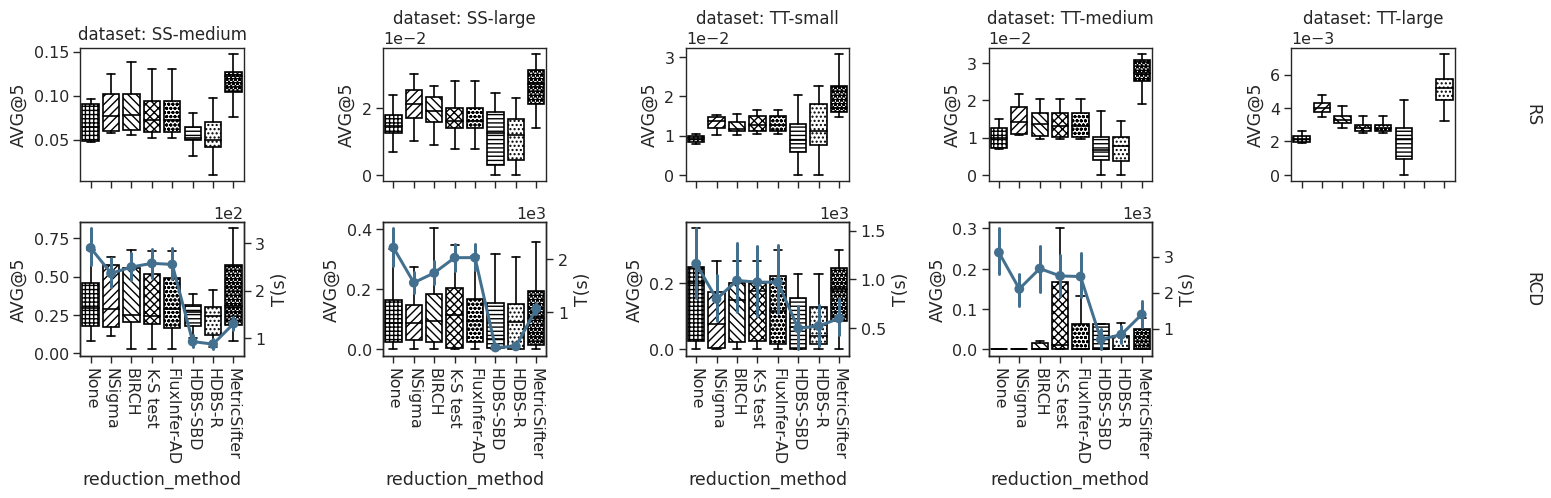

In [562]:
# remove localization methods that perform less well than RS

plot_grid(datasets[1:], loc_methods=["RS", "RCD"], col="dataset", row="localization_method")


/tmp/ipykernel_3717222/1637822629.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


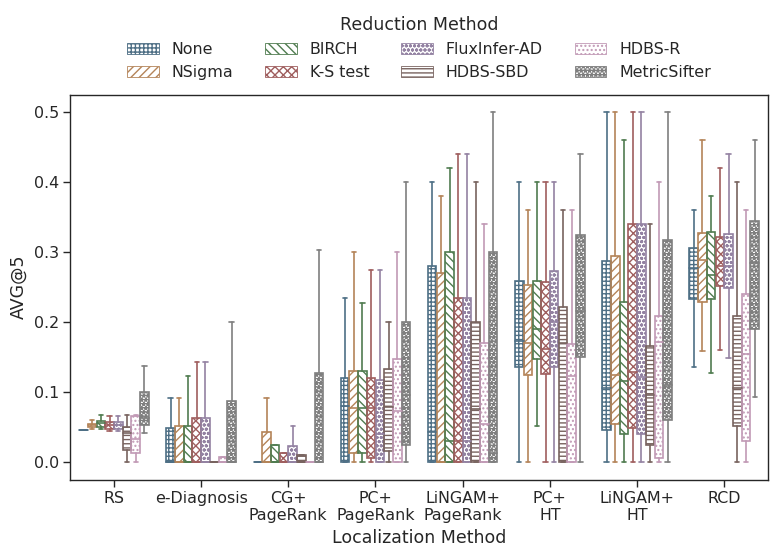

In [542]:
plot_combination("SS-small", "avg@5", "AVG@5", loc_methods=LOC_METHODS)


/tmp/ipykernel_3717222/1637822629.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


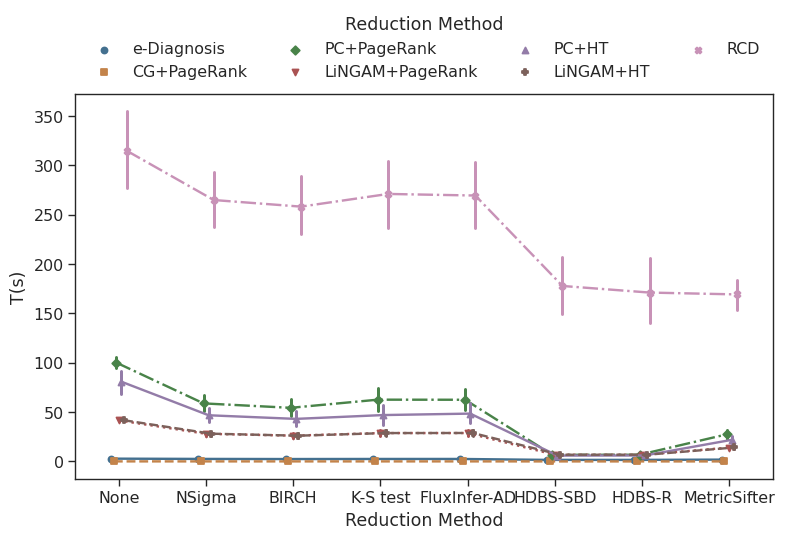

In [543]:
plot_combination("SS-small", "elapsed_time_loc", "T(s)", loc_methods=LOC_METHODS[1:], plot_type="point")


In [544]:
# num_metrics = pd.Series([100, 90, 80])
# num_found_metrics = pd.Series([2, 3, 1])

# def get_scores_of_random_selection(num_metrics: pd.Series, num_found_metrics: pd.Series, max_k: int = 5):

#     def ac_k(num_metrics, num_found_ground_truth, k: int):
#         n, g = num_metrics, num_found_ground_truth
#         prob_single_correct = g / n
#         prob_at_least_one_correct = 1 - (1 - prob_single_correct) ** k
#         return prob_at_least_one_correct.mean()

#     def avg_k(ac_k_) -> dict:
#         return {k: sum([ac_k_[j] for j in range(1, k + 1)]) / k for k in range(1, max_k + 1)}

#     ac_k_ = {k: ac_k(num_metrics, num_found_metrics, k) for k in range(1, max_k + 1)}
#     avg_k_ = avg_k(ac_k_)

#     return {f"AC_{k}": v for k, v in ac_k_.items()}, {f"AVG_{k}": v for k, v in avg_k_.items()}

# get_scores_of_random_selection(num_metrics, num_found_metrics)


## Ablation Study

In [553]:
# TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID = 894, 899
# TSDR_ABLATION_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID + 1)]
TSDR_ABLATION_RUN_IDS = [f"TSDR-{id}" for id in {1849,1850,1767,1868,1877,1818}]


In [554]:
def convert_to_step_name(phase: str) -> str:
    match phase:
        case "phase1":
            return "STEP0"
        case "phase2":
            return "STEP0-1"
        case "phase3":
            return "STEP0-3"
        case _:
            assert False, f"Unknown phase: {phase}"

def fetch_tsdr_metadata_by_phase(run_id: str) -> list[dict[str, str|float]]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return []
        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type

        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "MetricSifter"
            case (_, _, _, _, _):
                return []
                # assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        csv_path = f"/tmp/summary_by_phase-csv-{run_id}.csv"
        run["scores/summary_by_phase-csv"].download(destination=csv_path)
        summary_by_phase = pd.read_csv(csv_path)
        items = []
        for _, row in summary_by_phase.iterrows():  # skip phase1 simple filtering
            num_series = tuple([int(s) for s in row["num_series/total"].split("/")])
            num_found_cause_metrics = row["cause_metrics/num_mandatory_found_mean"]

            specificity = row["cause_metrics/specificity_mean"]
            recall = row["cause_metrics/recall_mandatory_mean"]
            bacc = row["cause_metrics/bacc_mean"]
            mcc = row["cause_metrics/mcc_mean"]
            elapsed_time = row["elapsed_time"]

            items.append({
                "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                "method": convert_to_step_name(row["phase"]),
                "phase": row["phase"],
                "specificity": specificity, "recall": recall, "bacc": bacc, "mcc": mcc,
                "elapsed_time": elapsed_time,
                "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                "rs_ac@2": row["RS_AC_2"], "rs_ac@5": row["RS_AC_5"], "rs_avg@5": row["RS_AVG_5"],
            })
        return items


In [555]:
tsdr_phase_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_tsdr_metadata_by_phase)(run) for run in TSDR_ABLATION_RUN_IDS)
assert tsdr_phase_items is not None
tsdr_phase_items = sum(tsdr_phase_items, [])
tsdr_phase_items = [item for item in tsdr_phase_items if item]


https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1818
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1850
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1868
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1849
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1877
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1850/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1849/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1877/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune

In [557]:
steps = ["STEP0", "STEP0-1", "STEP0-3"]
metrics = ["specificity", "recall", "bacc", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets

multi_level_indexes = pd.MultiIndex.from_product(
    [datasets, steps], names=['Dataset', 'Step'],
)
multi_level_cols = pd.MultiIndex.from_product(
    [datasets, metrics], names=['', ''],
)

tsdr_phase_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
    index=multi_level_indexes,
)
tsdr_phase_df["elapsed_time"] = tsdr_phase_df["elapsed_time"].cumsum()


In [558]:
tsdr_phase_df


phase  specificity    recall      bacc        mcc  \
Dataset   Step                                                          
SS-small  STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.120935  1.000000  0.560467  -0.583098   
          STEP0-3  phase3     0.346632  0.975000  0.660816   0.088060   
SS-medium STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.130083  1.000000  0.565041   0.052579   
          STEP0-3  phase3     0.457775  0.979167  0.718471   0.136381   
SS-large  STEP0    phase1     0.000000  1.000000  0.500000        NaN   
          STEP0-1  phase2     0.088772  0.998437  0.543605   0.020770   
          STEP0-3  phase3     0.493700  0.941810  0.717755   0.059565   
TT-small  STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.297582  0.928571  0.613077   0.028059   
          STEP0-3  phase3     0.548195  0.904762  0.726478   0.050718   
TT-medium STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.251748  0.952381  0.602065   0.028104   
          STEP0-3  phase3     0.655096  0.948413  0.801754   0.073770   
TT-large  STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.168255  0.976190  0.572223   0.010502   
          STEP0-3  phase3     0.650948  0.849773  0.750361   0.028442   

                   elapsed_time  num_metrics(reduced)  num_metrics(filtered)  \
Dataset   Step                                                                 
SS-small  STEP0        0.365774                    64                     64   
          STEP0-1      1.703604                    56                     64   
          STEP0-3      2.012875                    42                     64   
SS-medium STEP0        2.389689                   185                    185   
          STEP0-1      5.395778                   162                    185   
          STEP0-3      5.799625                   102                    185   
SS-large  STEP0        6.284793                  1347                   1347   
          STEP0-1     22.944237                  1229                   1347   
          STEP0-3     24.254431                   687                   1347   
TT-small  STEP0       24.825431                   329                    329   
          STEP0-1     29.810307                   233                    329   
          STEP0-3     30.589203                   149                    329   
TT-medium STEP0       31.373222                  1250                   1250   
          STEP0-1     48.030888                   937                   1250   
          STEP0-3     49.916507                   435                   1250   
TT-large  STEP0       51.577546                  9343                   9343   
          STEP0-1    151.041765                  7779                   9343   
          STEP0-3    164.622717                  3277                   9343   

                   num_metrics(raw)  num_found_cause_metrics   rs_ac@2  \
Dataset   Step                                                           
SS-small  STEP0                  80                 1.000000  0.030802   
          STEP0-1                80                 1.000000  0.035587   
          STEP0-3                80                 0.975000  0.051296   
SS-medium STEP0                 499                 4.437500  0.047151   
          STEP0-1               499                 4.437500  0.054288   
          STEP0-3               499                 4.337500  0.088676   
SS-large  STEP0                6793                 6.800000  0.010018   
          STEP0-1              6793                 6.787500  0.010952   
          STEP0-3              6793                 6.312500  0.018531   
TT-small  STEP0                 408                 1.000000  0.006176   
          STEP0-1               408                 0.928571  0.008070

In [559]:
import itertools

df_display = tsdr_phase_df[["specificity", "recall", "bacc", "elapsed_time"]]
tsdr_s = df_display.style
tsdr_s.clear()
# tsdr_s.highlight_max(subset=(itertools.product(datasets, steps), ["FRR", "RFR", "RFP"]), props='textbf:--rwrap;')\
#     .highlight_min(subset=(itertools.product(datasets, steps), ["elapsed_time"]), props='textbf:--rwrap;')
tsdr_s.format({"RFP": '{:.4f}'}, precision=3)
tsdr_s.set_table_styles([
    {'selector': 'toprule', 'props': ':toprule;'},
    {'selector': 'bottomrule', 'props': ':bottomrule;'},
], overwrite=False)

def highlight_max(s, props='textbf:--rwrap;'):
    is_max = s == s.max()
    return [props if v else '' for v in is_max]

def highlight_min(s, props='textbf:--rwrap;'):
    is_min = s == s.min()
    return [props if v else '' for v in is_min]

for dataset in datasets:
    tsdr_s.apply(highlight_max, subset=(itertools.product([dataset], steps), ["specificity", "recall", "bacc"]), axis=0)
    # tsdr_s.apply(highlight_min, subset=(itertools.product([dataset], steps), ["elapsed_time"]), axis=0)
print(tsdr_s.to_latex(hrules=True))


\begin{tabular}{llrrrr}
\toprule
 &  & specificity & recall & bacc & elapsed_time \\
Dataset & Step &  &  &  &  \\
\midrule
\multirow[c]{3}{*}{SS-small} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.366 \\
 & STEP0-1 & 0.121 & \textbf{1.000} & 0.560 & 1.704 \\
 & STEP0-3 & \textbf{0.347} & 0.975 & \textbf{0.661} & 2.013 \\
\multirow[c]{3}{*}{SS-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 2.390 \\
 & STEP0-1 & 0.130 & \textbf{1.000} & 0.565 & 5.396 \\
 & STEP0-3 & \textbf{0.458} & 0.979 & \textbf{0.718} & 5.800 \\
\multirow[c]{3}{*}{SS-large} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 6.285 \\
 & STEP0-1 & 0.089 & 0.998 & 0.544 & 22.944 \\
 & STEP0-3 & \textbf{0.494} & 0.942 & \textbf{0.718} & 24.254 \\
\multirow[c]{3}{*}{TT-small} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 24.825 \\
 & STEP0-1 & 0.298 & 0.929 & 0.613 & 29.810 \\
 & STEP0-3 & \textbf{0.548} & 0.905 & \textbf{0.726} & 30.589 \\
\multirow[c]{3}{*}{TT-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 31.373 \\
 & ST

In [551]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    multi_level_indexes = pd.MultiIndex.from_product([ss_datasets, steps], names=['Dataset', 'Step'])
    multi_level_cols = pd.MultiIndex.from_product(
        [ss_datasets, metrics], names=['', ''],
    )
    ss_tsdr_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
        index=multi_level_indexes,
    )
    df_pivot = ss_tsdr_df.unstack('Dataset')
    df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=steps, columns=multi_level_cols,
    )
    display(df_pivot)

import itertools

df_display = df_pivot[itertools.product(ss_datasets, ["FRR", "RFR", "RFP", "elapsed_time"])].copy()
# df_display.drop(index=["None"], inplace=True)
tsdr_s = df_display.style
tsdr_s.clear()
tsdr_s.highlight_max(subset=(steps, list(itertools.product(ss_datasets, ["FRR", "RFR", "RFP"]))), props='textbf:--rwrap;')\
    .highlight_min(subset=(steps, list(itertools.product(ss_datasets, ["elapsed_time"]))), props='textbf:--rwrap;')
tsdr_s.format({k: '{:.4f}' for k in itertools.product(ss_datasets, ["RFP"])}, precision=3)
print(tsdr_s.to_latex())


SS-small                               SS-medium                      \
              FRR    RFR       RFP elapsed_time       FRR       RFR       RFP   
Step                                                                            
STEP0    0.000000  1.000  0.015521     0.276900  0.000000  1.000000  0.023891   
STEP0-1  0.213769  0.950  0.019729     0.243784  0.244541  0.964583  0.031460   
STEP0-3  0.379029  0.925  0.026659     0.226514  0.478974  0.935000  0.046651   

                      SS-large                                   
        elapsed_time       FRR       RFR       RFP elapsed_time  
Step                                                             
STEP0       0.297339  0.000000  1.000000  0.005023     0.445994  
STEP0-1     0.358441  0.254490  0.963167  0.006453     1.485795  
STEP0-3     0.309034  0.557006  0.851227  0.009771     0.976439

\begin{tabular}{lrrrrrrrrrrrr}
 & \multicolumn{4}{r}{SS-small} & \multicolumn{4}{r}{SS-medium} & \multicolumn{4}{r}{SS-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Step &  &  &  &  &  &  &  &  &  &  &  &  \\
STEP0 & 0.000 & \textbf{1.000} & 0.0155 & 0.277 & 0.000 & \textbf{1.000} & 0.0239 & \textbf{0.297} & 0.000 & \textbf{1.000} & 0.0050 & \textbf{0.446} \\
STEP0-1 & 0.214 & 0.950 & 0.0197 & 0.244 & 0.245 & 0.965 & 0.0315 & 0.358 & 0.254 & 0.963 & 0.0065 & 1.486 \\
STEP0-3 & \textbf{0.379} & 0.925 & \textbf{0.0267} & \textbf{0.227} & \textbf{0.479} & 0.935 & \textbf{0.0467} & 0.309 & \textbf{0.557} & 0.851 & \textbf{0.0098} & 0.976 \\
\end{tabular}



In [552]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    multi_level_indexes = pd.MultiIndex.from_product(
        [tt_datasets, steps], names=['Dataset', 'Step'])
    multi_level_cols = pd.MultiIndex.from_product(
        [tt_datasets, metrics], names=['', ''])
    tt_tsdr_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
        index=multi_level_indexes)
    display(tt_tsdr_df)
    df_pivot = tt_tsdr_df.unstack('Dataset')
    df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=steps, columns=multi_level_cols,
    )
    display(df_pivot)

import itertools

df_display = df_pivot[itertools.product(tt_datasets, ["FRR", "RFR", "RFP", "elapsed_time"])].copy()
# df_display.drop(index=["None"], inplace=True)
tsdr_s = df_display.style
tsdr_s.clear()
tsdr_s.highlight_max(subset=(steps, list(itertools.product(tt_datasets, ["FRR", "RFR", "RFP"]))), props='textbf:--rwrap;')\
    .highlight_min(subset=(steps, list(itertools.product(tt_datasets, ["elapsed_time"]))), props='textbf:--rwrap;')
tsdr_s.format({k: '{:.4f}' for k in itertools.product(tt_datasets, ["RFP"])}, precision=3)
print(tsdr_s.to_latex())


phase       FRR       RFR       RFP  elapsed_time  \
Dataset   Step                                                          
TT-small  STEP0    phase1  0.000000  1.000000  0.003093      0.809967   
          STEP0-1  phase2  0.433013  0.928571  0.005002      0.919429   
          STEP0-3  phase3  0.603525  0.928571  0.007366      0.910940   
TT-medium STEP0    phase1  0.000000  1.000000  0.003438      0.890590   
          STEP0-1  phase2  0.430388  0.952381  0.005751      1.741464   
          STEP0-3  phase3  0.697163  0.943651  0.010825      1.551786   
TT-large  STEP0    phase1  0.000000  1.000000  0.000727      1.902519   
          STEP0-1  phase2  0.348138  0.976190  0.001092      9.436500   
          STEP0-3  phase3  0.714668  0.786281  0.001993      9.290333   

                   num_metrics(reduced)  num_metrics(filtered)  \
Dataset   Step                                                   
TT-small  STEP0                     329                    329   
          STEP0-1                   187                    329   
          STEP0-3                   131                    329   
TT-medium STEP0                    1250                   1250   
          STEP0-1                   714                   1250   
          STEP0-3                   380                   1250   
TT-large  STEP0                    9343                   9343   
          STEP0-1                  6098                   9343   
          STEP0-3                  2677                   9343   

                   num_metrics(raw)  num_found_cause_metrics   rs_ac@2  \
Dataset   Step                                                           
TT-small  STEP0                 408                 1.000000  0.006176   
          STEP0-1               408                 0.928571  0.009976   
          STEP0-3               408                 0.928571  0.014668   
TT-medium STEP0                2857                 4.285714  0.006862   
          STEP0-1              2857                 4.142857  0.011464   
          STEP0-3              2857                 4.095238  0.021519   
TT-large  STEP0               57697                 6.785714  0.001454   
          STEP0-1             57697                 6.642857  0.002184   
          STEP0-3             57697                 5.428571  0.003981   

                    rs_ac@5  rs_avg@5  
Dataset   Step                         
TT-small  STEP0    0.015367  0.009239  
          STEP0-1  0.024733  0.014895  
          STEP0-3  0.036201  0.021845  
TT-medium STEP0    0.017057  0.010260  
          STEP0-1  0.028381  0.017103  
          STEP0-3  0.052832  0.031956  
TT-large  STEP0    0.003632  0.002180  
          STEP0-1  0.005450  0.003272  
          STEP0-3  0.009919  0.005960

TT-small                                  TT-medium            \
              FRR       RFR       RFP elapsed_time       FRR       RFR   
Step                                                                     
STEP0    0.000000  1.000000  0.003093     0.809967  0.000000  1.000000   
STEP0-1  0.433013  0.928571  0.005002     0.919429  0.430388  0.952381   
STEP0-3  0.603525  0.928571  0.007366     0.910940  0.697163  0.943651   

                                TT-large                                   
              RFP elapsed_time       FRR       RFR       RFP elapsed_time  
Step                                                                       
STEP0    0.003438     0.890590  0.000000  1.000000  0.000727     1.902519  
STEP0-1  0.005751     1.741464  0.348138  0.976190  0.001092     9.436500  
STEP0-3  0.010825     1.551786  0.714668  0.786281  0.001993     9.290333

\begin{tabular}{lrrrrrrrrrrrr}
 & \multicolumn{4}{r}{TT-small} & \multicolumn{4}{r}{TT-medium} & \multicolumn{4}{r}{TT-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Step &  &  &  &  &  &  &  &  &  &  &  &  \\
STEP0 & 0.000 & \textbf{1.000} & 0.0031 & \textbf{0.810} & 0.000 & \textbf{1.000} & 0.0034 & \textbf{0.891} & 0.000 & \textbf{1.000} & 0.0007 & \textbf{1.903} \\
STEP0-1 & 0.433 & 0.929 & 0.0050 & 0.919 & 0.430 & 0.952 & 0.0058 & 1.741 & 0.348 & 0.976 & 0.0011 & 9.437 \\
STEP0-3 & \textbf{0.604} & 0.929 & \textbf{0.0074} & 0.911 & \textbf{0.697} & 0.944 & \textbf{0.0108} & 1.552 & \textbf{0.715} & 0.786 & \textbf{0.0020} & 9.290 \\
\end{tabular}

